In [102]:
#
# This notebook is for solving the first task from ML course
# Most of this code was taken from https://github.com/andriygav/MachineLearningSeminars/tree/master
# and modified for the purposes of the task
#
# It was run on python 3.10 with libs from requirements.txt 
# although I may have forgotten some of them for visualisation
#

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms

# For interactive plots - makes my pc lag so I did not use it
# !pip install ipympl
# %matplotlib widget

import plotly.express as px
from sklearn.metrics import mean_squared_error, root_mean_squared_error


In [94]:
from sklearn.datasets import load_diabetes
ds = load_diabetes(as_frame=True, scaled=False)
x,y,df = ds.data, ds.target, ds.frame
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


## Diabetes dataset

Ten baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

All variables are real numbers and target is a also real number.

As seen from plots below, dataset does not seem to have a lot of outliers. But, it is also hard to see any strong correlations or dividing dots by colors (they're mixed up a lot)

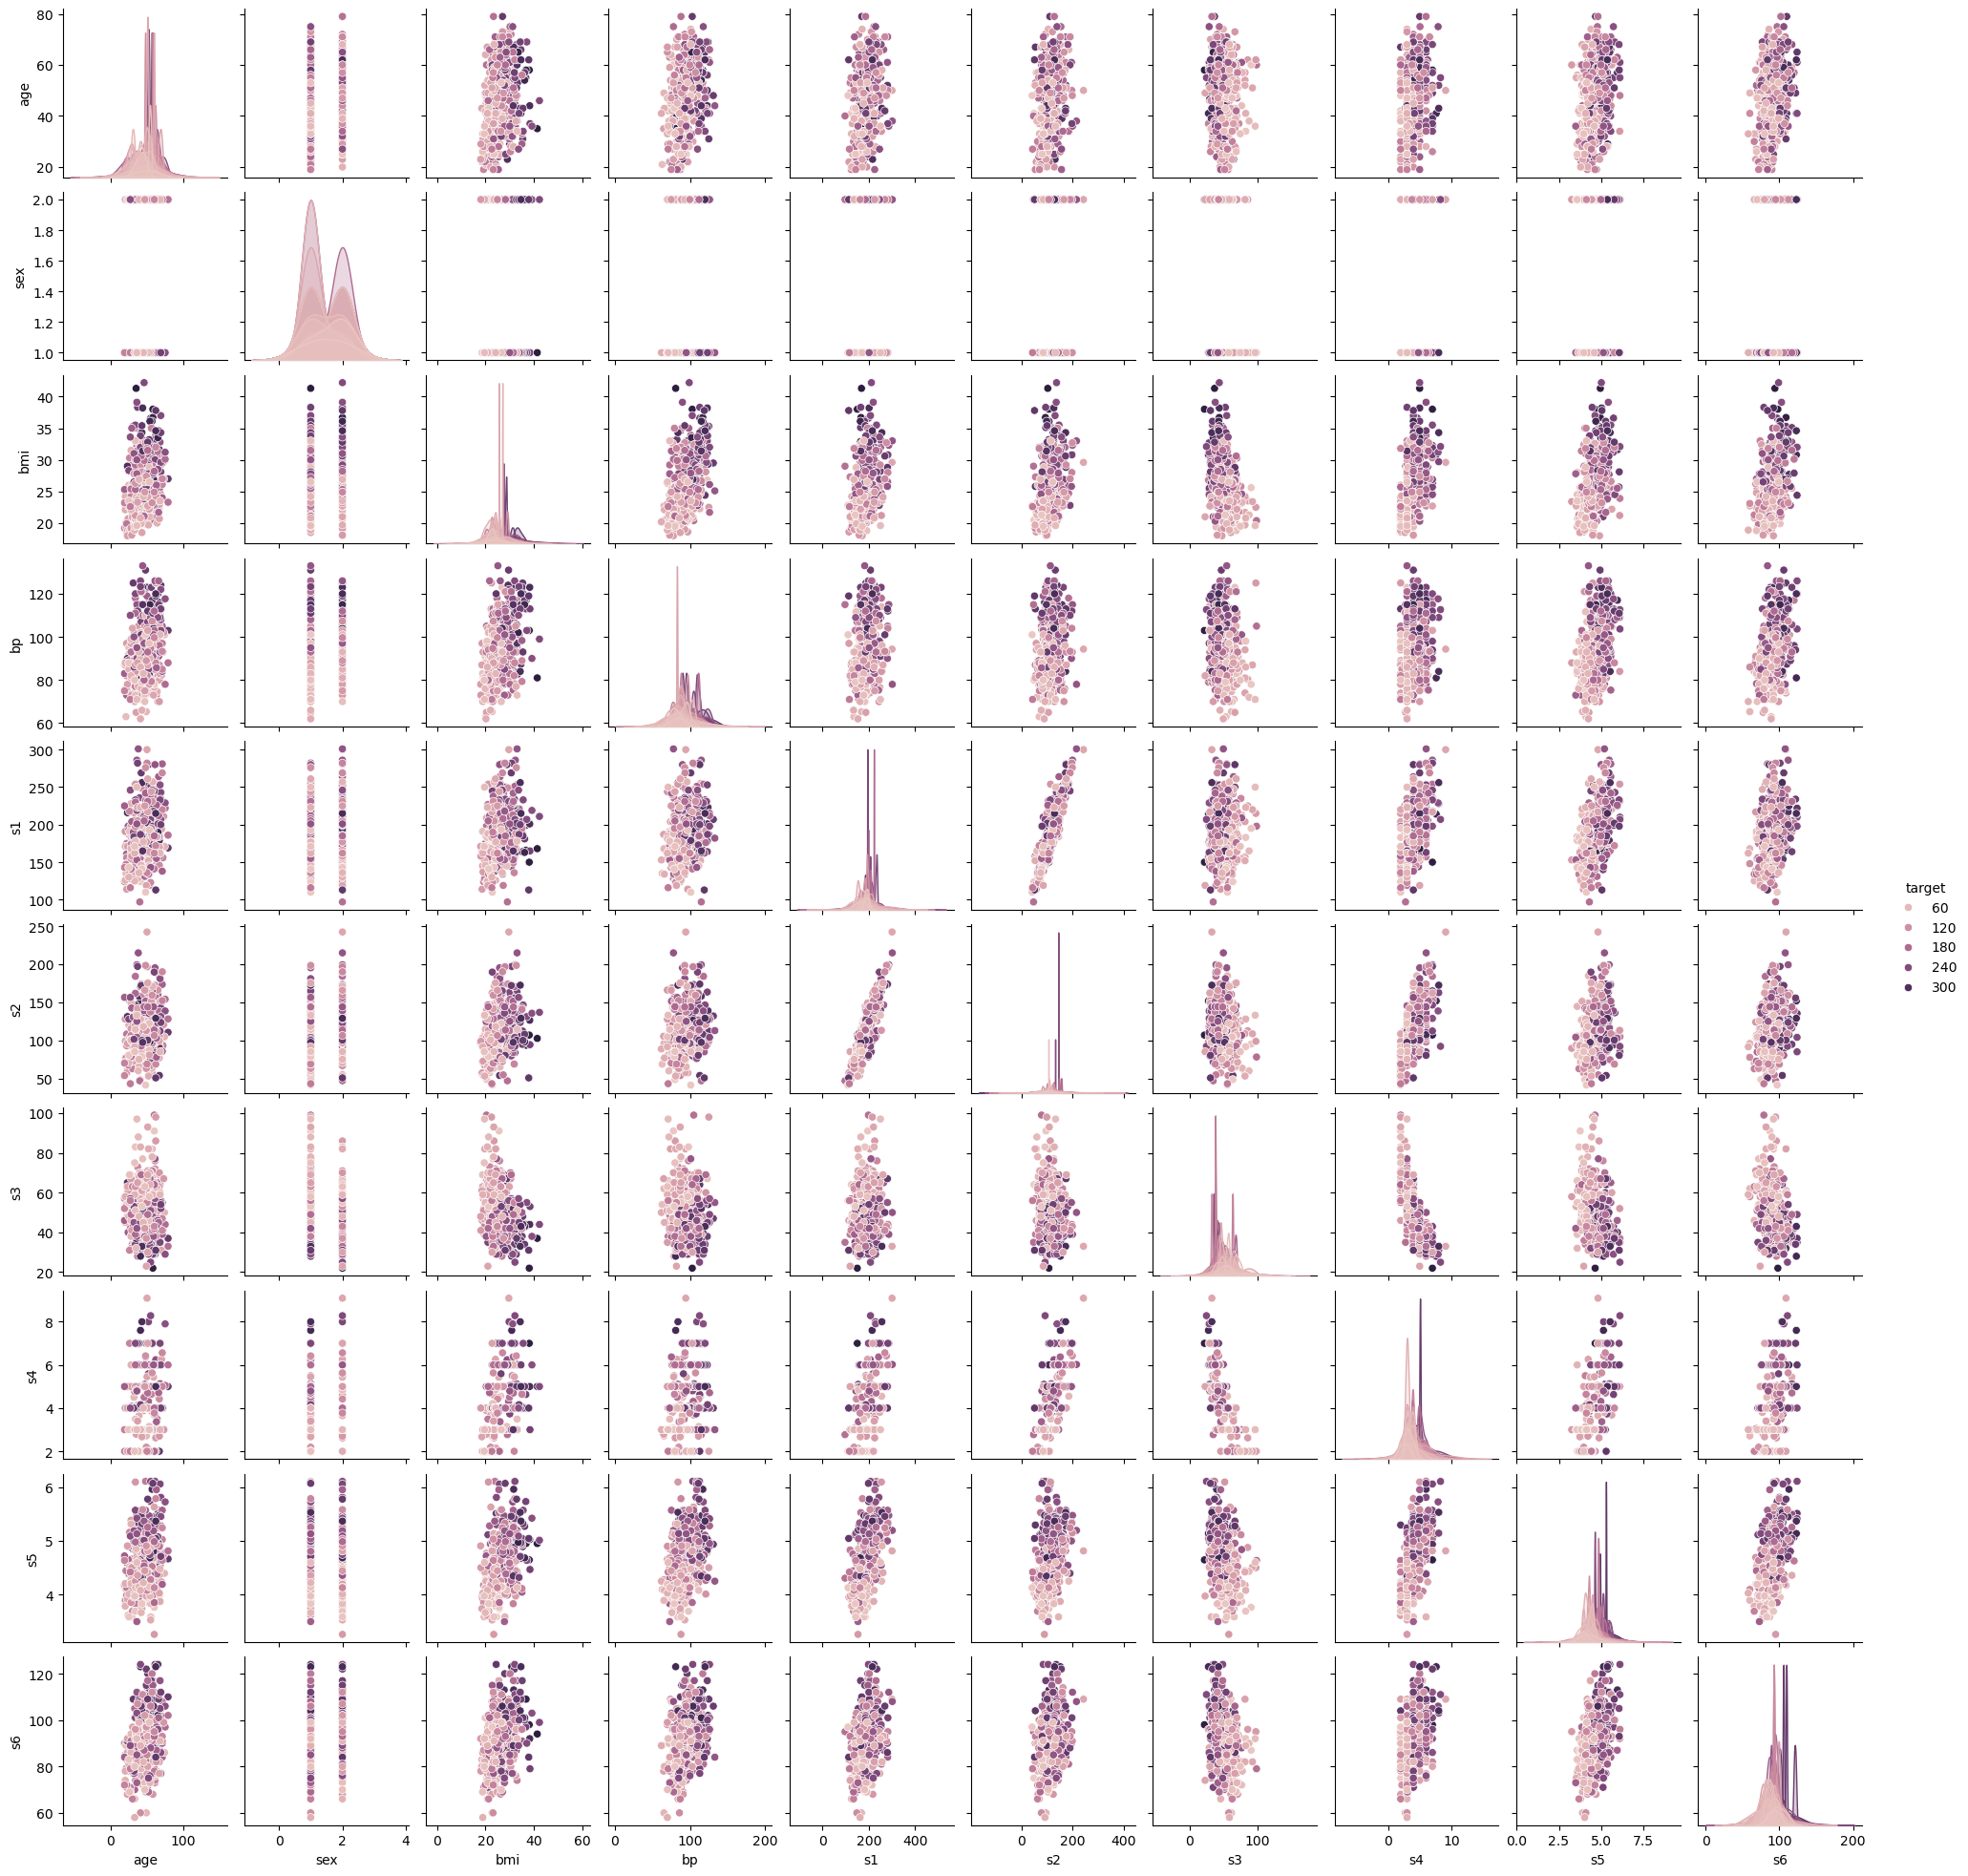

In [95]:
sns.pairplot(df, hue='target', height=2)

In [96]:
ds = load_diabetes(scaled=True, as_frame=True).frame
ds = ds.sample(frac=1).reset_index(drop=True) # shuffling
ds['ones'] = 1.
y = ds['target'].values.copy()
ds = ds.drop(columns=['target'])
x = ds.values

For purpose of the task, dataset was divided into two parts: train (333 elements) and test (109 elements). Which gives division rate of ~75%:25%

This dataset has normalised features from library (obtained by `scale` option). However, target is not normalised.

In [32]:
x_tr, y_tr = x[:333], y[:333]
x_ts, y_ts = x[333:], y[333:]

## Linear (SVD)

For linear regression, SVD method is used for LSM calculation with reguralisation.

In [34]:
X = x_tr
V, d, U = np.linalg.svd(X, full_matrices=False)
D = np.eye(len(d))*d
lambd = d**2
np.max(lambd)/np.min(lambd)
list(zip(lambd, ds.columns))

[(333.004041292454, 'age'),
 (3.0885898261152747, 'sex'),
 (1.138827722894358, 'bmi'),
 (0.9140671950874255, 'bp'),
 (0.7187234334705139, 's1'),
 (0.49339777289040637, 's2'),
 (0.45919693154711405, 's3'),
 (0.42557191249660087, 's4'),
 (0.2960220789914487, 's5'),
 (0.05731014471293816, 's6'),
 (0.006871265017121119, 'ones')]

Reguralisation parameter `tau` is obtained by brute force. It does not seem to matter much as seen from plot below. Actually, the best value seems to be 0 so no deep search was done

In [105]:
# sort for pretty plot
sorted_indices = np.argsort(y_ts)
x_ts_sr = x_ts[sorted_indices]
y_ts_sr = y_ts[sorted_indices]

out_df = [pd.DataFrame({'y': list(y_ts_sr), 't': ['real']*len(y_ts), 'x': list(range(len(y_ts)))})]
for tau in [0, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10]:
    W = (U.T@D@np.linalg.inv(D**2 + tau*np.eye(len(D)))@V.T)@y_tr
    out_df.append(pd.DataFrame({
        'y': x_ts_sr@W,
        't': [f'{tau=} rmse={root_mean_squared_error(y_ts_sr, x_ts_sr@W):.1f}']*len(y_ts),
        'x': range(len(y_ts))
    }))

px.line(pd.concat(out_df), y='y', color='t', x='x').show()

## Perceprton

For another way of predicting, perceptron was used. It is fully-connected neural network

In [104]:
# needed for pytorch interface
train_set =  tuple(zip(x_tr.astype(np.float32), y_tr.astype(np.float32)))
test_set = tuple(zip(x_ts.astype(np.float32), y_ts.astype(np.float32)))

In [109]:
import torch.nn.functional as F

class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
    
    def __init__(self, input_dim=11, num_layers=0, 
                 hidden_dim=11, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        prev_size = input_dim
        
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
            
        self.layers.add_module('regressor', 
                               torch.nn.Linear(prev_size, output_dim))

    def forward(self, input):
        return self.layers(input).squeeze(-1)  # to remove the last dimension

def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    for x, y in generator:
        x = x.view([-1, 11]).to(device) # TODO do i need it for vectors?
        y = y.to(device)
        pred.extend(model(x).cpu().detach().numpy().tolist())
    return pred

def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        for x, y in generator:
            optimizer.zero_grad()
            x = x.view([-1, 11]).to(device)  # TODO do i need it for vectors?
            y = y.to(device)
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

hparams = [(5, .05, 2000), (5, .1, 2000), (5, .0, 2000), (11, .05, 1500), (11, .05, 1500), (2, .0, 4000)]

out_df = [pd.DataFrame({'y': list(y_ts_sr), 't': ['real']*len(y_ts), 'x': list(range(len(y_ts)))})]

for layers, p, epochs in hparams:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Perceptron(num_layers=layers, p=p)
    model.to(device)

    _ = model.train()
    trainer(model=model, 
            dataset=train_set, 
            loss_function=torch.nn.MSELoss(), 
            optimizer=torch.optim.Adam(model.parameters(), lr=0.01), 
            epochs=epochs)

    _ = model.eval()
    pred = testing(model, test_set)
    pred = np.array(pred)[sorted_indices]
    out_df.append(pd.DataFrame({
        'y': pred,
        't': [f'{layers=} {p=} {epochs=} rmse={root_mean_squared_error(y_ts_sr, pred):.1f}']*len(y_ts),
        'x': range(len(y_ts))
    }))

px.line(pd.concat(out_df), y='y', color='t', x='x').show()

## SVM

Last but not least, SVM is another method for numerical regression. Several methods were used, but again, hyperparams did not matter much. Except for C, which default value made model predict just mean value, so it was changed to pretty big number

In [112]:
from sklearn.svm import SVR
hparams = [{'kernel': 'linear', 'C': 1},  {'kernel': 'linear', 'C': 100}, 
           {'kernel': 'linear', 'C': 1e4}, {'kernel': 'rbf', 'C': 1e4},
           {'kernel': 'poly', 'C': 1e4, 'degree': 3}, {'kernel': 'poly', 'degree': 5}]


out_df = [pd.DataFrame({'y': list(y_ts_sr), 't': ['real']*len(y_ts), 'x': list(range(len(y_ts)))})]

for hp in hparams:
    model = SVR(**hp)
    _ = model.fit(x_tr, y_tr)
    res = model.predict(x_ts_sr)
    out_df.append(pd.DataFrame({
        'y': res,
        't': [f'{hp=} rmse={root_mean_squared_error(y_ts_sr, res):.1f}']*len(y_ts),
        'x': range(len(y_ts))
    }))

px.line(pd.concat(out_df), y='y', color='t', x='x').show()


## Conclusion

Overall, dataset seems to be lacking some features required for correct prediction. It seems to be okay since it has no outliers and visually looks appealing but all 3 methods (with tons of combination of hyperparams) don't seem to give accurate predictions. Moreover, all of them give almost the same looking plots with minor differences in RMSE. So, either it is impossible to predict accurately, or it lacks features, or feature-engineering is required as regular models (linear, poly, etc) can't predict target behaviour